# Introduction

For this second milestone in the project, we're going to explore data in relation to the theme we've defined. In the code below, we'll mainly be using datasets from finished paths, a little from unfinished paths, adjacent matrices and shortest paths. This will allow us to carry out an initial analysis of our data.

# Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import *
from data_quantity_analysis import *
from cliches import *
from plot_helpers import *

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Preprocessing

In [16]:
(
    articles,
    categories,
    links,
    paths_finished,
    paths_unfinished,
) = import_and_clean_data()

# Data quantity analysis - exploratory data analysis

## General 

We start by exploring the data set to get an overview of the data and the information it provides. As a first step, we're trying to create graphs that could potentially give us information about how players play and think.

As the aim of our project is to look at the role of clichés in the choice of artworks by users and, more generally, the role they play in information, we begin by looking at the sub-sets of data that contain the most information.

Here we look at the 100 most visited articles by players and then the 100 most used targets, both among the finished paths.

[('<', 16009), ('United_States', 8654), ('Europe', 4270), ('United_Kingdom', 3806), ('England', 3260), ('Earth', 3152), ('Africa', 2742), ('World_War_II', 2256), ('North_America', 1829), ('Germany', 1737), ('Animal', 1642), ('France', 1570), ('Human', 1554), ('Mammal', 1548), ('Computer', 1513), ('Science', 1453), ('Periodic_table', 1396), ('English_language', 1392), ('Brain', 1301), ('Atlantic_Ocean', 1266), ('Telephone', 1239), ('India', 1210), ('Viking', 1193), ('Bird', 1183), ('Asia', 1164), ('Asteroid', 1164), ('Agriculture', 1111), ('Plant', 1105), ('China', 1104), ('Christianity', 1052), ('Japan', 1051), ('United_Nations', 1039), ('Zebra', 1029), ('Theatre', 1027), ('Internet', 1001), ('Russia', 995), ('Australia', 980), ('Chemistry', 973), ('London', 938), ('Sun', 914), ('Canada', 897), ('South_America', 891), ('European_Union', 877), ('Adolf_Hitler', 872), ('Water', 868), ('Solar_System', 857), ('President_of_the_United_States', 833), ('Italy', 832), ('Physics', 829), ('Chemic

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/data_quantity_analysis.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=article_names, y=article_counts, palette="coolwarm")


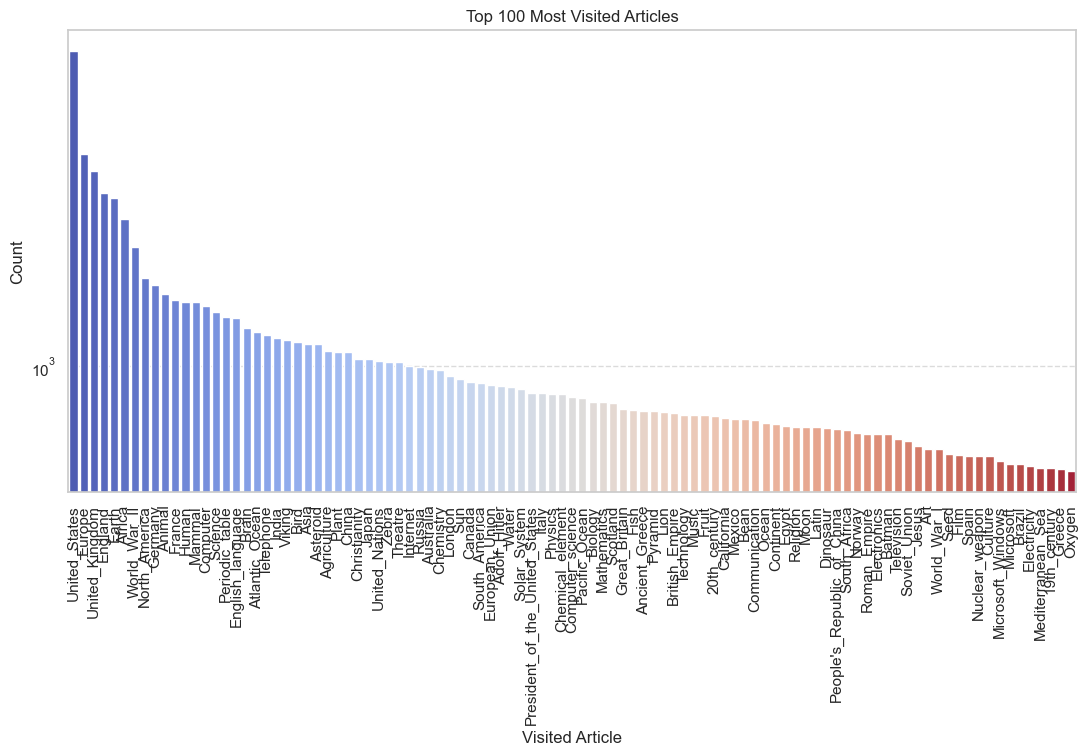

In [17]:
top_100_visited_articles(paths_finished, show=True)

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/data_quantity_analysis.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_100_targets.index, y=top_100_targets.values, palette="coolwarm")


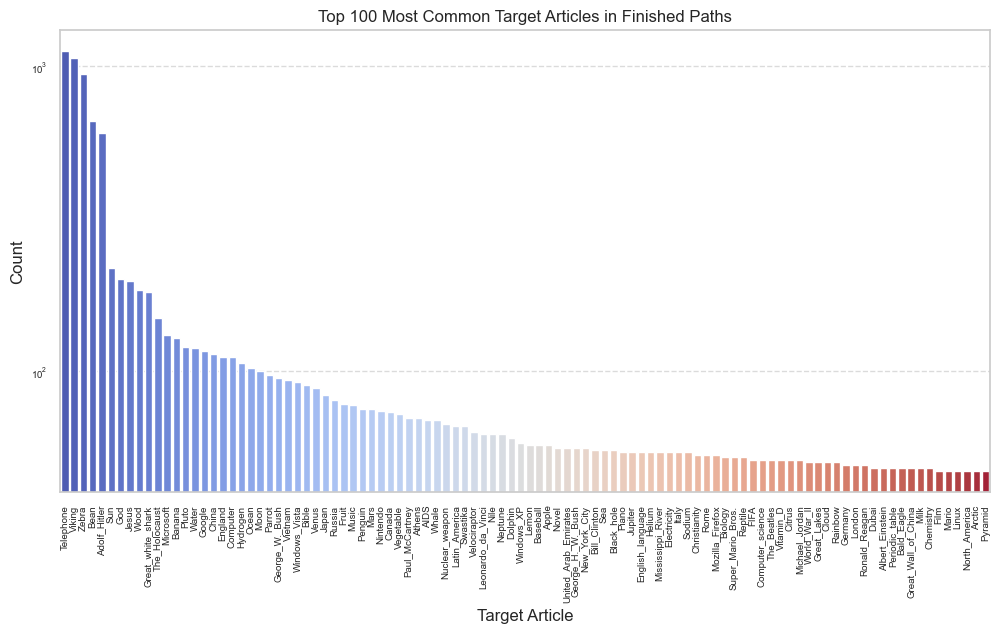

In [18]:
top_100_target_articles(paths_finished, show=True)

We then look at the distribution of the length and duration of the finished paths to see if these correspond to a normal trend or if there are particular features to be analysed.

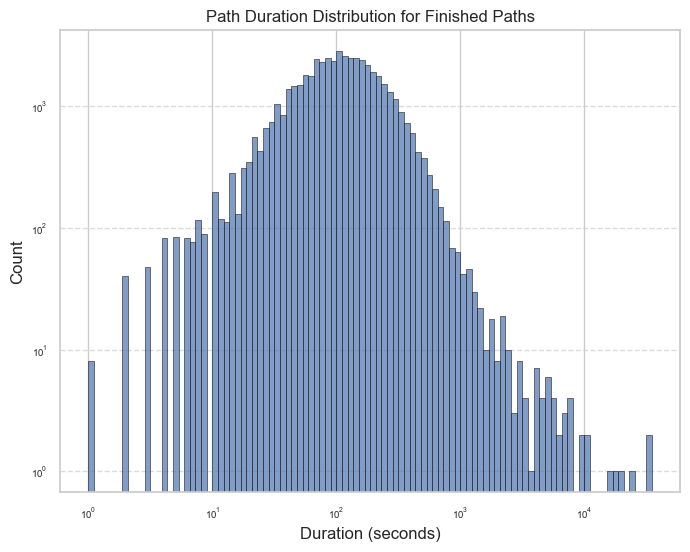

In [19]:
path_duration_distribution(paths_finished, show=True)

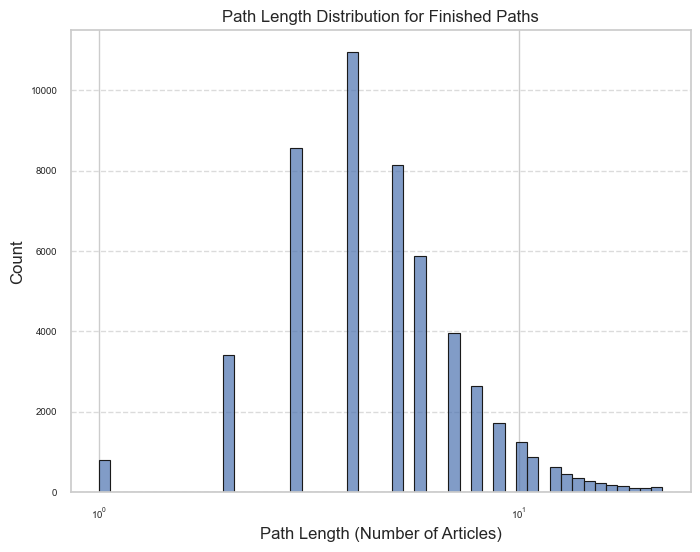

In [20]:
path_length_distribution(paths_finished, show=True)

Now that we've looked at distributions with a single valuer, we'll look at the links between several valuers: in particular, we'll look at the interaction between the length of the path and the length of the game's duration, and then the interaction between the score given to the chmin and its length.

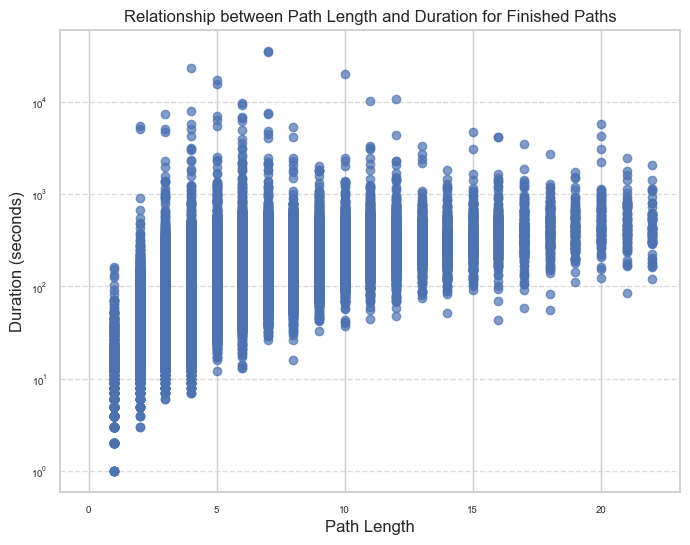

In [21]:
path_length_vs_duration(paths_finished, show=True)

<Figure size 1000x900 with 0 Axes>

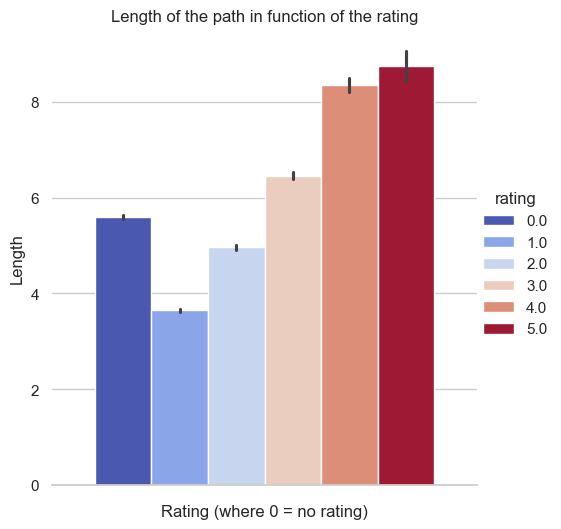

In [22]:
rating_vs_path_length(paths_finished, show=True)

Based on the previous two plots, we could hypothesize that the length of the path is correlated to the duration of the game and its rating, simply based on the apparent monotonicity of the data.
Both these interpretations are intuitive but we should perform a statistical regressions and tests to confirm them.

## Specific example: the United Kingdom

Now that we've looked at the data as a whole, let's take a closer look at one data set in particular, that of United Kingdom. This will allow us to define a set of snapshots for this particular area. We've decided to use United Kingdom as an example because it's one of the most visited items in the dataset and as one of our european neighbors, we can easily find clichés that are true.

In [23]:
main_article = "United_Kingdom"

In [24]:
count_in_out_neighbors(paths_finished, paths_unfinished, main_article)

Number of paths finished that contain United Kingdom: 3732
Number of paths unfinished that contain UnitedKingdom 1354
Number of paths that finished with United Kingdom: 28


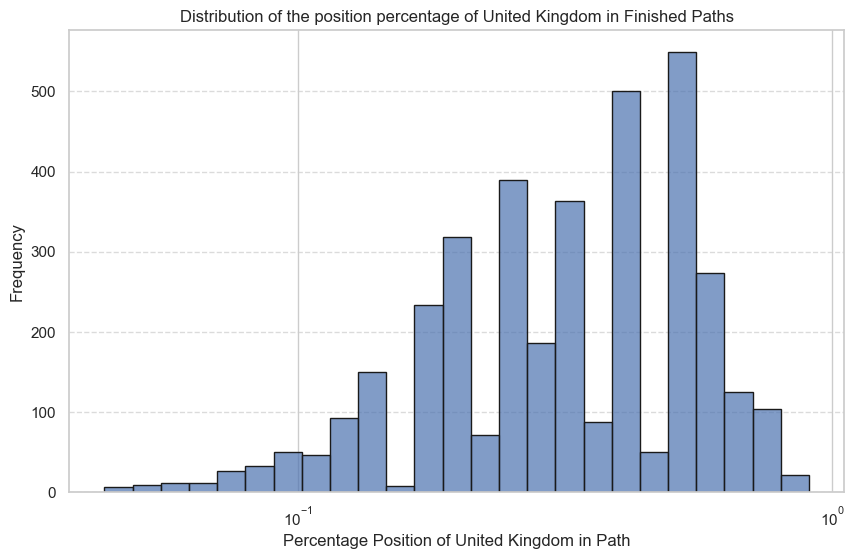

In [25]:
distribution_position_percentage(paths_finished, main_article, show=True)

In generality, we can't really infer any particular distribution from the data. However, in future analysis we could try to fit distributions when we consider the position of the main article conditonally on additional events (e.g. the path also contains a particular cliché).

### TODO: add martin's plots here

In [27]:
# define main_article for analysis: 
main_article = "United_Kingdom"

# only keep rows such that main_article in path
around_main_article = get_df_main_article(paths_finished, main_article=main_article).copy(deep=True)

# get category of the main_article
around_main_article["main_article_category"] = around_main_article["path"].apply(lambda path: get_category_main_article(main_article, path, categories))

# article juste before/just after main_article
# TODO: function to be improved/discussed. What do we want to do with "<"?
around_main_article["around_path"] = around_main_article["path"].apply(
    lambda path: get_index_main_article_in(main_article, path)
)

# update initial/target_article, initial/target_category
around_main_article["around_IA"] = around_main_article["around_path"].apply(
    lambda path: path[0]
)
around_main_article["around_TA"] = around_main_article["around_path"].apply(
    lambda path: path[-1]
)
around_main_article["around_IC"] = around_main_article["around_IA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)
around_main_article["around_TC"] = around_main_article["around_TA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)

around_main_article

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,shortest_path,diff_length,target_article,keyword_category,around_path,around_IA,around_TA,around_IC,around_TC
74,565e6dc60eeca66c,1253358736,77,"[Aberdeen, City_status_in_the_United_Kingdom, ...",0.0,5,3,2,Bread,[Geography],"[Aberdeen, City_status_in_the_United_Kingdom, ...",Aberdeen,Market,[Geography],[Business_Studies]
113,4dc8af51482ebb5a,1336876538,221,"[Achilles, Ethiopia, United_Kingdom, World_War...",3.0,4,2,2,Winston_Churchill,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
115,0adc390d00c8c538,1344743190,63,"[Achilles, Greek_mythology, Ancient_Greece, Eu...",3.0,6,2,4,Winston_Churchill,"[Countries, Geography, Geography]","[Europe, United_Kingdom, Prime_Minister_of_the...",Europe,Prime_Minister_of_the_United_Kingdom,[Geography],[Citizenship]
117,31980f901eee5467,1346717015,117,"[Achilles, Ethiopia, United_Kingdom, World_War...",0.0,4,2,2,Winston_Churchill,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
121,3a11233c52f824f8,1350896212,224,"[Achilles, William_Shakespeare, England, Great...",0.0,7,2,5,Winston_Churchill,"[Countries, Geography, Geography]","[<, United_Kingdom, World_War_II]",<,World_War_II,[],[History]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51280,6f4978c43a8faffd,1358871308,164,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",0.0,5,4,1,British_monarchy,"[History, People]","[Industrial_Revolution, George_III_of_the_Unit...",Industrial_Revolution,British_monarchy,[History],[Citizenship]
51287,4e3201ac6a75f14f,1324457682,150,"[Tropical_Storm_Larry_(2003), Pacific_Ocean, U...",3.0,8,3,5,Magna_Carta,"[Countries, Geography, Geography]","[Pacific_Ocean, United_Kingdom, England]",Pacific_Ocean,England,[Geography],[Geography]
51299,3cc4f2837bf22048,1325177555,59,"[Union_Station_(San_Diego), World_War_II, Unit...",0.0,4,2,2,Bristol,"[Countries, Geography, Geography]","[World_War_II, United_Kingdom, England]",World_War_II,England,[History],[Geography]
51301,3278e904185ec5bc,1361584612,168,"[Valparaíso, World_Heritage_Site, Europe, <, U...",0.0,10,3,7,Hellenistic_Greece,"[Countries, Geography, Geography]","[<, United_Kingdom, United_Nations]",<,United_Nations,[],[Citizenship]


/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/plot_helpers.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


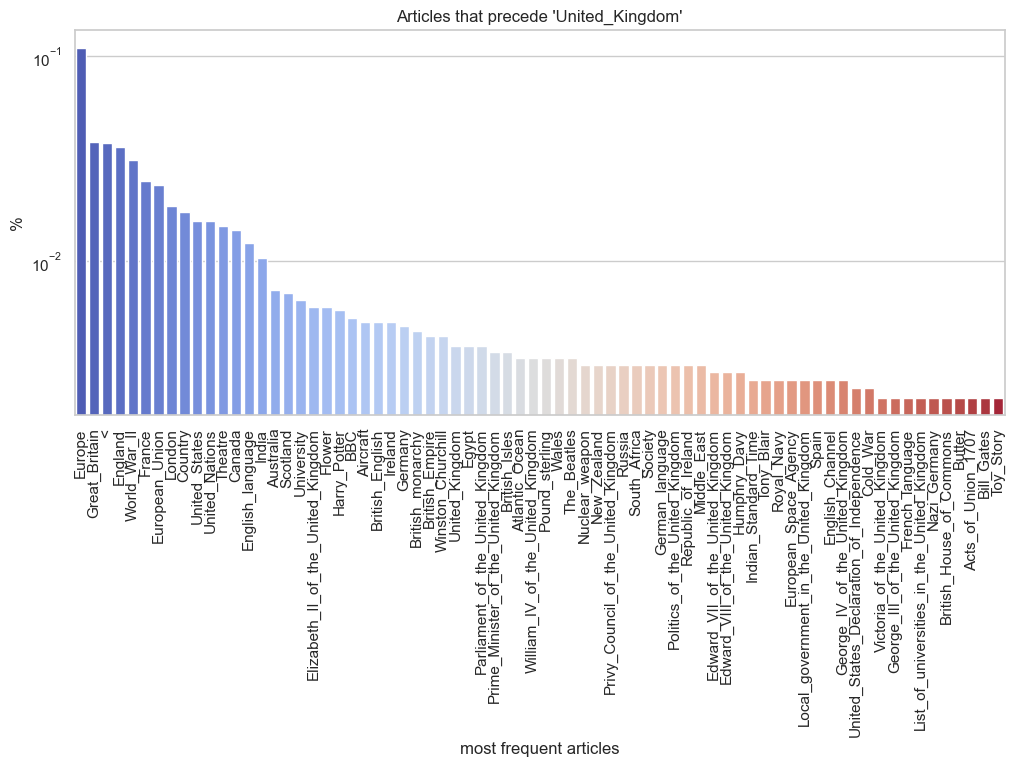

In [28]:
# keep only 10% most frequent articles just after key_word
most_frequent_before = around_key_word["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/plot_helpers.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


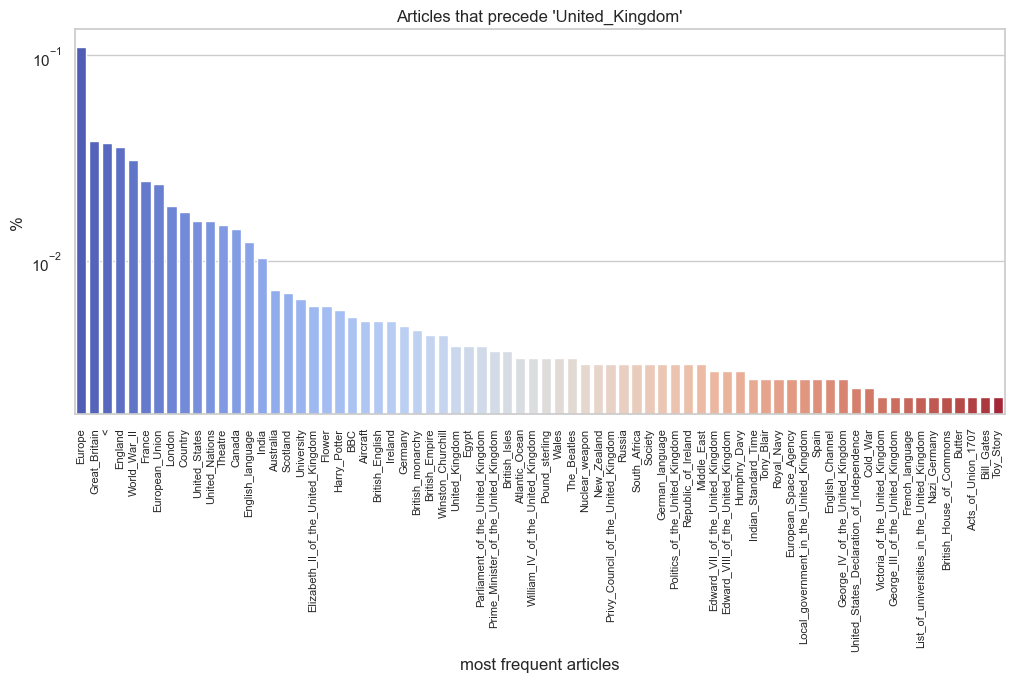

In [29]:
# keep only 10% most frequent articles just after key_word
most_frequent_before = around_key_word["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

# Define our cliches 

## Cliches preprocessing

In this section we will define and extract data from the clichés. This will enable us to carry out analyses to discover whether or not there are any links between our chosen subject and the clichés.

## Statistical tests for difference of path length for different cliches

From the key word "United_Kingdom", we can extract some "cliche" articles (eg below). For a given rating and cliche, is there a statistical difference in the difference path length (actual path length - shortest path)?

In [30]:
# select some cliches
key_word_cliches = [
    "Harry_Potter",
    "BBC",
    "Winston_Churchill",
    "The_Beatles",
    "Elizabeth_II_of_the_United_Kingdom",
    "Flower",
    "British_monarchy",
    "British_Empire",
    "Prime_Minister_of_the_United_Kingdom",
    "Pound_sterling",
    "London",
]

ratings = np.arange(1, 6, dtype=int)

In [31]:
# for some reasons, the classic from cliches import * does not work ...
from cliches import test_difference_path_length_cliche

# create dataframe
test_cliche = pd.DataFrame(
    columns=[
        "keyword",
        "cliche",
        "rating",
        "mean_cliche",
        "mean_nocliche",
        "shape_cliche",
        "shape_nocliche",
        "statistic",
        "p_value",
    ]
)

# test different ratings and cliches
for rating in ratings:
    for cliche in key_word_cliches:
        (
            stat,
            p,
            mean_path_cliche,
            mean_path_nocliche,
            shape_cliche,
            shape_nocliche,
        ) = test_difference_path_length_cliche(
            paths_finished, rating, cliche, "United_Kingdom", False, False
        )
        test_cliche.loc[test_cliche.shape[0]] = [
            "United_Kingdom",
            cliche,
            rating,
            mean_path_cliche,
            mean_path_nocliche,
            shape_cliche,
            shape_nocliche,
            stat,
            p,
        ]

test_cliche.head()

/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,keyword,cliche,rating,mean_cliche,mean_nocliche,shape_cliche,shape_nocliche,statistic,p_value
0,United_Kingdom,Harry_Potter,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
1,United_Kingdom,BBC,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
2,United_Kingdom,Winston_Churchill,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
3,United_Kingdom,The_Beatles,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
4,United_Kingdom,Elizabeth_II_of_the_United_Kingdom,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN


# Categories and cliches (working title)

In [32]:
all_categories, subcategories1, subcategories2, subcatgeories3 = separate_categories(categories)

Non-coincide Categories at 1 step away from UK: [('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'Citizenship'), ('United_Kingdom', 'Politics_and_government'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History')]
Non-coincide Categories at 2 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900')]
Non-coincide Categories at 3 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geogra

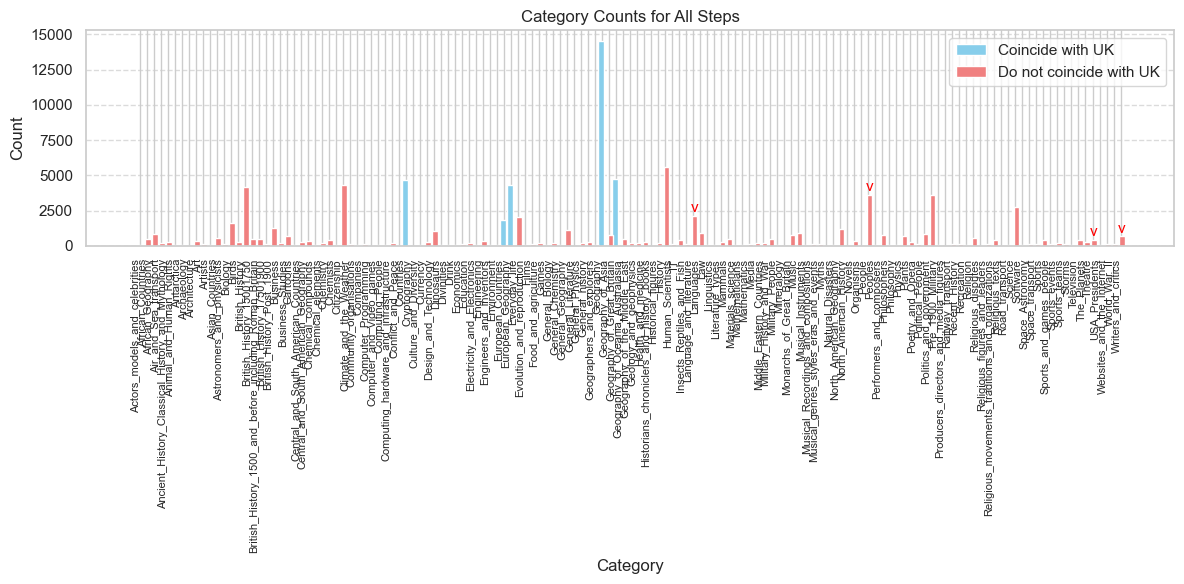

In [33]:
combine_results(paths_finished, categories, all_categories, ["category1", "category2", "category3"])